In [25]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, ReLU, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.initializers import GlorotNormal
# from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# 데이터 준비

In [2]:
painting = pd.read_csv('painting.csv')
painting.head()

,file,title,artist,genre,style
0,Realism/vincent-van-gogh_pine-trees-in-the-fen...,pine-trees-in-the-fen-1884,vincent-van-gogh,landscape,Realism
1,Baroque/rembrandt_the-angel-appearing-to-the-s...,the-angel-appearing-to-the-shepherds-1634,rembrandt,religious painting,Baroque
2,Post_Impressionism/paul-cezanne_portrait-of-th...,portrait-of-the-artist-s-son,paul-cezanne,portrait,Post_Impressionism
3,Impressionism/pierre-auguste-renoir_young-girl...,young-girl-seated-in-a-meadow-1916,pierre-auguste-renoir,genre painting,Impressionism
4,Romanticism/ivan-aivazovsky_morning-1851.jpg,morning-1851,ivan-aivazovsky,marina,Romanticism


In [3]:
painting_lst = np.load('../data/data.npy')
painting_lst.shape

(80158, 128, 128, 3)

In [4]:
# 1. X, y 데이터 준비 (painting_lst와 painting['style'])
X = painting_lst       # (80158, height, width, channels) 형태
y = painting['style']  # 스타일 정보 (문자형 라벨)

In [6]:
# y 라벨 인코딩 (문자형 → 숫자로 변환)
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)  # 장르를 숫자로 변환

# y 원핫 인코딩 (Neural Network에서 학습 가능하도록 변환)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_labels.reshape(-1, 1))

In [7]:
# 스타일별 데이터 개수 확인
style_counts = y.value_counts()
style_ratios = style_counts / style_counts.sum()  # 장르별 비율 유지

In [8]:
# 각 스타일에서 샘플링할 개수 설정
total_samples = 40000
samples_per_style = (style_ratios * total_samples).astype(int)
samples_per_style[samples_per_style == 0] = 2  # 최소 2개 이상 유지

In [9]:
# 샘플링 수행 (각 장르에서 비율 유지)
selected_indices = []

for style, sample_count in samples_per_style.items():
    style_indices = y[y == style].index.tolist()  # 특정 장르의 인덱스 가져오기
    sampled_indices = np.random.choice(style_indices, sample_count, replace=False)  # 랜덤 샘플링
    selected_indices.extend(sampled_indices)  # 최종 리스트에 추가

X_sample = X[selected_indices]  # 이미지 샘플링
y_sample = y_onehot[selected_indices]  # y 샘플링

print(f"X_sample.shape={X_sample.shape}, y_sample.shape={y_sample.shape}")

X_sample.shape=(39984, 128, 128, 3), y_sample.shape=(39984, 27)


In [10]:
# train-test 데이터 분할 (stratify=y_sample으로 클래스 균형 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, stratify=y_sample, shuffle=True)

print(f"X_train={X_train.shape}, X_test={X_test.shape}")

X_train=(27988, 128, 128, 3), X_test=(11996, 128, 128, 3)


In [11]:
# 학습 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rotation_range=20,  # 0~20도 회전
    width_shift_range=0.1,  # 가로 이동 (최대 10%)
    height_shift_range=0.1,  # 세로 이동 (최대 10%)
    shear_range=0.2,  # 전단 변형
    zoom_range=0.2,  # 확대/축소 (20%)
    horizontal_flip=True,  # 좌우 반전
    fill_mode="nearest"  # 빈 픽셀을 가장 가까운 값으로 채움
)

# 증강된 학습 데이터 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

# 검증 데이터는 증강 없이 사용
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(X_test, y_test, batch_size=64)

# AlexNet

In [12]:
# AlexNet 모델
class AlexNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=len(label_encoder.classes_)):
        model = Sequential([
            Input(shape=input_shape),
            
            # 첫 번째 합성곱 레이어 + ReLU + Dropout
            Conv2D(32, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.5),
            
            # 두 번째 합성곱 레이어 + ReLU + Dropout
            Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.5),
            
            # 세 번째 합성곱 레이어 + ReLU + Dropout
            Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.5),
                     
            # 평탄화
            Flatten(),
            
            # 완전 연결 레이어 + Dropout
            Dense(512, activation='relu'),
            Dropout(0.5),
            
            # 출력 레이어 (소프트맥스)
            Dense(num_classes, activation='softmax')
        ])
        return model

In [13]:
# 5. 모델 생성 (num_classes는 레이블 수에 맞게 설정)
model = AlexNet.build(input_shape=(128, 128, 3), num_classes=len(label_encoder.classes_))
model.summary()

# 6. 모델 컴파일
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,303,835 (16.42 MB)

 Trainable params: 4,303,643 (16.42 MB)

 Non-trainable params: 192 (768.00 B)

In [14]:
# 7. 모델 학습
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

hist = model.fit(
    X_train, y_train,
    epochs=30,  # 에포크 수 설정
    batch_size=32,  # 배치 크기 설정
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 78ms/step - accuracy: 0.1496 - loss: 3.6186 - val_accuracy: 0.1910 - val_loss: 2.6650
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 76ms/step - accuracy: 0.1926 - loss: 2.6820 - val_accuracy: 0.1981 - val_loss: 2.6271
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.1982 - loss: 2.6257 - val_accuracy: 0.2248 - val_loss: 2.6257
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.2177 - loss: 2.5614 - val_accuracy: 0.2301 - val_loss: 2.5291
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.2265 - loss: 2.5257 - val_accuracy: 0.2337 - val_loss: 2.4687
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.2355 - loss: 2.4831 - val_accuracy: 0.2053 - val_loss: 2.6698
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 75s 86ms/step - accuracy: 0.2471 - loss: 2.4406 - val_accuracy: 0.2037 - val_loss: 2.6037
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 76s 87ms/step - accuracy: 0.2516 - loss: 2.4234 - 

In [15]:
# 8. 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:.2f}%'.format(accuracy * 100))

375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3220 - loss: 2.1630
Test accuracy: 32.17%


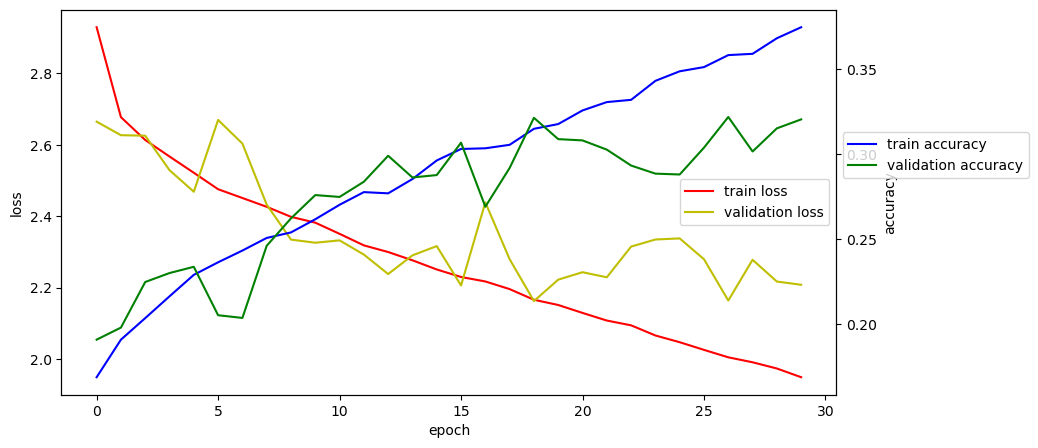

In [16]:
# 9. 학습과정 표시
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))

plt.show()

In [ ]:
# model.save("model/cnn_AlexNetmodel.h5")
# print("🎉 모델 저장 완료!")

# VGGNet

In [35]:
# VGGNet 모델
class VGGNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=None):
        if num_classes is None:
            raise ValueError("num_classes must be specified")
        
        model = Sequential([
            Input(shape=input_shape),
            
            # 첫 번째 합성곱 레이어 + ReLU + Dropout
            Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.3),
            
            # 두 번째 합성곱 레이어 + ReLU + Dropout
            Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.3),
            
            # 세 번째 합성곱 레이어 + ReLU + Dropout
            Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.3),
            
            # 평탄화
            Flatten(),
            
            # 완전 연결 레이어 + Dropout
            Dense(128, activation='relu'),
            Dropout(0.3),
            
            # 출력 레이어 (소프트맥스)
            Dense(num_classes, activation='softmax')
        ])
        return model

In [36]:
# 5. 모델 생성 (num_classes는 레이블 수에 맞게 설정)
num_classes = len(label_encoder.classes_)  # 실제 데이터셋의 클래스 수로 설정
model = VGGNet.build(input_shape=(128, 128, 3), num_classes=num_classes)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,124,795 (8.11 MB)

 Trainable params: 2,124,571 (8.10 MB)

 Non-trainable params: 224 (896.00 B)

In [37]:
# 6. 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# 7. 모델 학습
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

hist = model.fit(
    X_train, y_train,
    epochs=30,     # 에포크 수 설정
    batch_size=32,  # 배치 크기 설정
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 116s 131ms/step - accuracy: 0.1366 - loss: 3.2839 - val_accuracy: 0.1777 - val_loss: 2.7134
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 127s 145ms/step - accuracy: 0.1735 - loss: 2.7776 - val_accuracy: 0.1839 - val_loss: 2.6606
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 122s 139ms/step - accuracy: 0.1835 - loss: 2.7043 - val_accuracy: 0.1846 - val_loss: 2.6392
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 121s 138ms/step - accuracy: 0.1867 - loss: 2.6801 - val_accuracy: 0.2028 - val_loss: 2.6310
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 121s 138ms/step - accuracy: 0.1879 - loss: 2.6379 - val_accuracy: 0.2059 - val_loss: 2.6189
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 121s 138ms/step - accuracy: 0.1933 - loss: 2.6100 - val_accuracy: 0.2017 - val_loss: 2.6616
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 123s 140ms/step - accuracy: 0.1954 - loss: 2.6066 - val_accuracy: 0.2133 - val_loss: 2.5746
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 125s 143ms/step - accuracy: 0.1989 -

In [39]:
# 8. 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:.2f}%'.format(accuracy * 100))

375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2694 - loss: 2.4343
Test accuracy: 26.74%


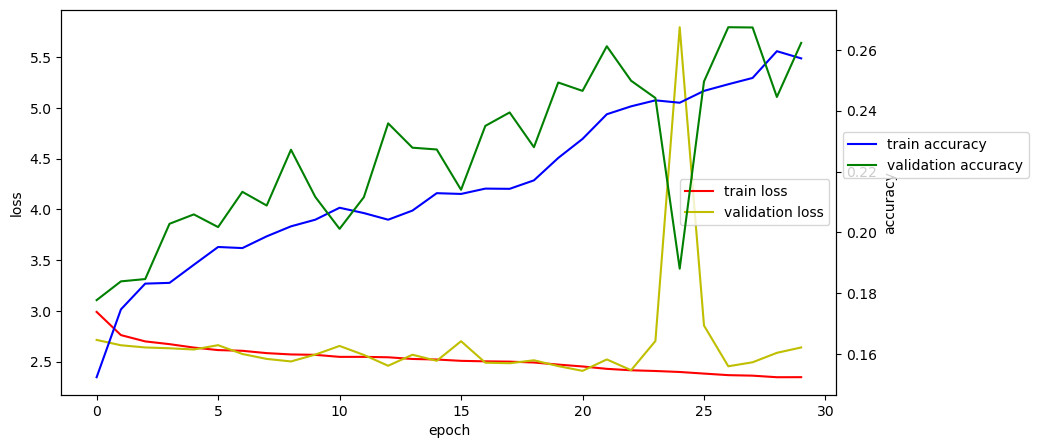

In [40]:
# 9. 학습과정 표시
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))

plt.show()

In [ ]:
# model.save("model/cnn_VGGNetmodel.h5")
# print("🎉 모델 저장 완료!")

# LeNet

In [51]:
# LeNet 모델 정의
class LeNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=None):
        if num_classes is None:
            raise ValueError("num_classes must be specified")
        
        model = Sequential([
            Input(shape=input_shape),
            
            # 첫 번째 합성곱 레이어 + ReLU
            Conv2D(16, kernel_size=(5, 5), activation='relu', kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.2),
            
            # 두 번째 합성곱 레이어 + ReLU
            Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.2),

            # 세 번째 합성곱 레이어 + ReLU
            Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.2),
            
            # 평탄화
            Flatten(),
            
            # 완전 연결 레이어 + Dropout
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            
            # 출력 레이어 (소프트맥스)
            Dense(num_classes, activation='softmax')
        ])
        return model

In [52]:
# 5. 모델 생성 (num_classes는 레이블 수에 맞게 설정)
num_classes = len(label_encoder.classes_)  # 실제 데이터셋의 클래스 수로 설정
model = LeNet.build(input_shape=(128, 128, 3), num_classes=num_classes)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,134,267 (8.14 MB)

 Trainable params: 2,133,787 (8.14 MB)

 Non-trainable params: 480 (1.88 KB)

In [53]:
# 6. 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# 7. 모델 학습
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

hist = model.fit(
    X_train, y_train,
    epochs=30,  # 에포크 수 설정 (작게 시작해도 좋습니다)
    batch_size=32,  # 배치 크기 설정
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 172s 195ms/step - accuracy: 0.1840 - loss: 2.9636 - val_accuracy: 0.1876 - val_loss: 2.9257
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 182s 208ms/step - accuracy: 0.2732 - loss: 2.3413 - val_accuracy: 0.2538 - val_loss: 4.4705
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 190s 217ms/step - accuracy: 0.3155 - loss: 2.1820 - val_accuracy: 0.2495 - val_loss: 2.5782
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 192s 219ms/step - accuracy: 0.3442 - loss: 2.0781 - val_accuracy: 0.3139 - val_loss: 2.2171
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 184s 210ms/step - accuracy: 0.3973 - loss: 1.8809 - val_accuracy: 0.2896 - val_loss: 2.4181
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 191s 218ms/step - accuracy: 0.4411 - loss: 1.7190 - val_accuracy: 0.3209 - val_loss: 2.2850
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 194s 222ms/step - accuracy: 0.5070 - loss: 1.5237 - val_accuracy: 0.3039 - val_loss: 2.3261
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 193s 220ms/step - accuracy: 0.5721 -

In [55]:
# 8. 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:.2f}%'.format(accuracy * 100))

375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.3208 - loss: 2.2895
Test accuracy: 32.09%


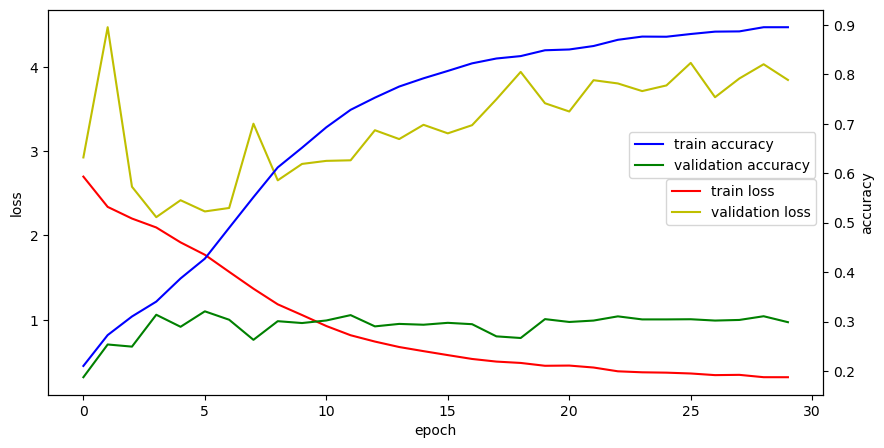

In [56]:
# 9. 학습과정 표시
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))

plt.show()

In [ ]:
# model.save("model/cnn_LeNetmodel.h5")
# print("🎉 모델 저장 완료!")